## Отчет по лабороторной работе №2

### Задание 1: запуск graph500 на локальной машине

Тесты выполнялись на машине со следующими характеристиками:
* Intel Core i7 6700HQ (4 cores, 2.60 GHz, 6M cache)
* 16 GB RAM
* OS: Ubuntu 14.04

Скачал тест с сайта http://www.graph500.org/ и собрал со включенным флагом omp. Дальше тестировал реализацию openmp для различных размеров матриц. Часть тестов находится в файле [graph500_omp_results.txt](graph500_omp_results.txt). Лучший полученный результат получился для scale = 20:

<pre>
min_TEPS: 0.00000000000000000e+00
firstquartile_TEPS: 0.00000000000000000e+00
median_TEPS: 1.31345518657892513e+09
thirdquartile_TEPS: 1.54346423943803215e+09
max_TEPS: 2.05866782797089076e+09
harmonic_mean_TEPS: 2.74703677273188543e+09
harmonic_stddev_TEPS: 3.22997755636200249e+08
</pre>

Результат = 2.74 GTEPS, что соответствует 144 месту в списке Graph500.

### Задание 2: запуск graph500 на кластер

Кластер состоял из 4-ех машин:
1. Graph500-1
    * CPU: Intel Core i7 6700HQ (4 cores, 2.60 GHz, 6M cache)
    * RAM: 16 GB RAM DDR4
    * Storage: 500 GB SSD
    * OS: Ubuntu 14.04
+  Graph500-2
    * CPU: Core i5-5300U (2 cores, 2.7 GHz, 3M cache)
    * RAM: 8GB DDR3L
    * Storage: 256 GB SSD
    * OS: Ubuntu 16.04
+  Graph500-3
    * CPU: AMD Athlon II X2 (2 cores, 2.1GHz, 2M cache)
    * RAM: 2 GB RAM DDR3L
    * Storage: 500 GB HDD
    * OS: Ubuntu 16.04
+  Graph500-4
    * CPU: Intel Core i5 3210M (4 cores, 2.50GHz, 3M cache)
    * RAM: 8 GB DDR3
    * Storage: 500 GB HDD
    * OS: Ubuntu 14.04

Для каждой из машин был собрал из исходников и установлен mpich версии 3.2. Далее, скачан тест с сайта http://www.graph500.org/ и собран с включением флага mpi. Все машины были объединены в локальную сеть через маршрутизатор TP-LINK, на каждой был создан пользователь graph500 и для каждой пары машин было настроено ssh соединение.

Запуск производился с помощью команды (пример для 4-х машин):

<pre>
mpirun -n 4 -f hostfile graph500/mpi/graph500_mpi_simple 12 16
</pre>

Причем, сначала для одной машины, потом для двух, потом для трех и для четырех. Тесты проводились для scale = 12 и подробный лог лежит в файле [graph500_mpi_cluster_results.txt](graph500_mpi_cluster_results.txt)

Пример лога для одной машины:

<pre>
min_TEPS:                       1.9412e+07
firstquartile_TEPS:             2.97869e+07
median_TEPS:                    2.98824e+07
thirdquartile_TEPS:             2.99492e+07
max_TEPS:                       3.06061e+07
harmonic_mean_TEPS:             2.9231e+07
harmonic_stddev_TEPS:           282672
</pre>

Результат для одной машины = 0.027, что соответствует 210 месту в рейтинге Graph500. Данный результат можно объяснить тем, что данный код не оптимизирован под запуск на одной машине, тем более в один поток.

Пример лога для четырех машин:

<pre>
min_TEPS:                       685592
firstquartile_TEPS:             2.00253e+06
median_TEPS:                    2.46504e+06
thirdquartile_TEPS:             3.1085e+06
max_TEPS:                       6.08788e+06
harmonic_mean_TEPS:             2.3268e+06
harmonic_stddev_TEPS:           121596
</pre>

Результат для четырех = 0.002 GTEPS, что соответствует последнему месту в рейтинге Graph500. Данный результат можно объяснить накладными расходами, возникающими из-за передачи по сети, нешироким каналом соединения, возможно, сильными различиями характеристик машин.

### Задание 3: Исследование графов Кронекера

Сначала, с помощью модуля (generator_test_seq), отвечающего за генерацию графов в тесте graph500 было сгенерировано 2000 графов с параметром scale = 12, причем в качестве сидов для генерации использовались сиды, сгенерированные приложением [seed-generator.cpp](seed-generator.cpp) (было удобно иметь набор, по которому всегда генерировались бы одни и те же графы). Каждый из графов сохранялся в отдельном файле как список ребер.

Далее, графы обрабатывались модулем собранным из [blocked-fw-cuda.cu](blocked-fw-cuda.cu) с помощью скрипта [compile_cuda.bat](compile_cuda.bat). Запуск модуля для каждого графа производилась скриптом [run_floyd_warshall.bat](run_floyd_warshall.bat).

Обработка включала в себя:
1. Чтение входного файла и сохранение в памяти в виде матрицы смежности
+  Запуск алгоритма Флойда-Уоршелла, реализованного на GPU для поиска расстояний между любыми двумя парами вершин в графе
+  Рассчет среднего расстояния между вершинами в графе, его диаметра, оценка связности
+  Выделение компонент связности, подсет их количество, определение размера большей из них

Все результаты складывались в файл [graphs_count_2000_scale_12_results.txt](graphs_count_2000_scale_12_results.txt)

Скрипт далее рассчитывает средние значения для каждой из характеристик.

In [1]:
import math

with open("graphs_count_2000_scale_12_results.txt") as f:
    diameter = 0
    avg_dist = 0.0
    conn = 0
    comp_count = 0
    max_comp_size = 0
    for line in f:
        parts = line.split(":")
        if (parts[0].startswith("Diameter")):
            diameter += int(parts[1])
        elif (parts[0].startswith("Average distance")):
            avg_dist += float(parts[1])
        elif (parts[0].startswith("Connected")):
            conn += int(parts[1])
        elif (parts[0].startswith("Connectivity components count")):
            comp_count += int(parts[1])
        elif (parts[0].startswith("Max component size")):
            max_comp_size += int(parts[1])
            
    print "Средние значения для 2000 графов:"
    print "\tДиаметр :", diameter / float(2000)
    print "\tСреднее расстояние между вершинами :", avg_dist / float(2000)
    print "\tВероятность связности :", conn / float(2000)
    print "\tКоличество компонент связности :", comp_count / float(2000)
    print "\tРазмер наибольшей компоненты связности :", max_comp_size / float(2000)

Средние значения для 2000 графов:
	Диаметр : 5.872
	Среднее расстояние между вершинами : 2.6482402
	Вероятность связности : 0.0
	Количество компонент связности : 751.6405
	Размер наибольшей компоненты связности : 3344.7655


Можно заметить несколько любопытных закономерностей:
1. Диаметр графов получился в районе 6, а среднее расстояние между вершинами невысоко, что подтверждает теорию рукопожатий для данной модели.
+  Ни один из сгенерированных графов не оказался связным, что в принципе понятно, особенно для небольших графов (я исследовал графы 2^12)
+  Исходя из параметров, касающихся компонент связности, можно говорить о том, что в среднем мы имеем одну большую компоненту связности, а также много изолированных вершин (это будет визуально подтверждено на графиках распределения)

Для исследования распределения степеней вершин был написан модуль [graph-distribution-analyzer.cpp](graph-distribution-analyzer.cpp), который для каждого входного графа считает распределение, а также считает среднее среди всех графов. Результат хранится в файле [graphs_count_2000_scale_12_average_distribution.txt](graphs_count_2000_scale_12_average_distribution.txt).

Построим распределение на графике:

In [2]:
%matplotlib inline
import matplotlib.pyplot as pyplot

def draw_distrib(filename, xmax, ymax):
    with open(filename) as f:
        lines = f.readlines()
    distrib = [[int(line.split(" ")[0]), float(''.join(line.split(" ")[1][:-1]))] for line in lines[1:]]
    fig = pyplot.figure(figsize=(17,5), dpi=90)
    #fig.suptitle(title , fontsize = 20)
    pyplot.plot([_[0] for _ in distrib], [_[1] for _ in distrib])
    #pyplot.plot(xrange(1, xmax), [c / d^3 for d in xrange(1, xmax)])
    pyplot.xlim([0, xmax])
    pyplot.ylim([0, ymax])
    pyplot.xticks(range(0, xmax + 10, (xmax + 10) / 25))
    pyplot.yticks(range(0, ymax + 10, (ymax + 10) / 9))
    pyplot.xlabel("Vertex degree")
    pyplot.ylabel("Count")
    pyplot.show()

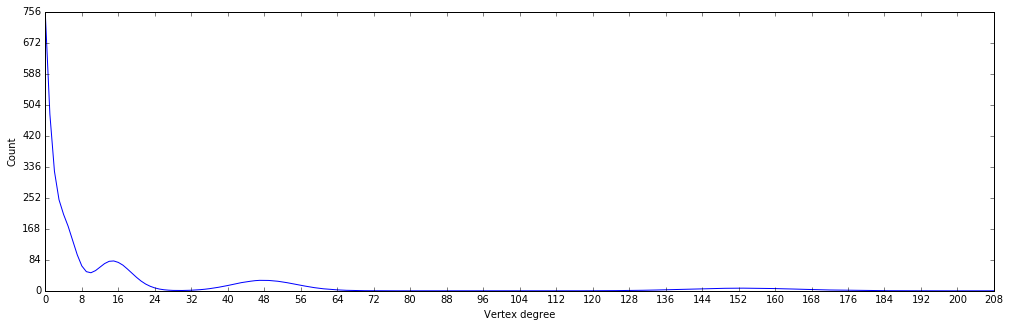

In [3]:
draw_distrib('graphs_count_2000_scale_12_average_distribution.txt', 200, 750)

Выводы по графику:
* видно большое количество изолированных вершин, что соответствует средним параметрам рассчитанным ранее
* есть некоторые скачки в некоторых точках, однако, в среднем можно говорить о степенном определении, что соответствует теории
* если просмотреть на сами файлы распределений, то можно заметить, что вершин со степенями больше 200 крайне мало, однако они всегда есть (наибольшая степень вершины среди сгенерированных графов = 5136)

В целом результаты соответствуют теории, описывающей модель Кронекера.

### Задание 4: Исследование графов Боллобаша-Риордана

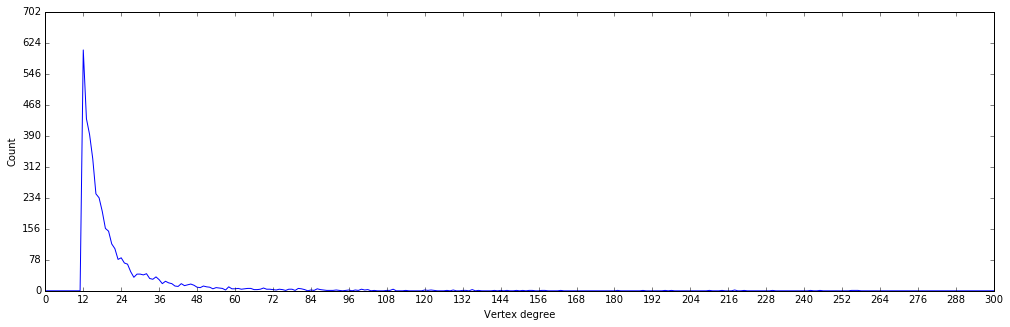

In [4]:
draw_distrib('bollobas-riordan-graph-distributions\output_4096_12.txt.distribution', 300, 700)

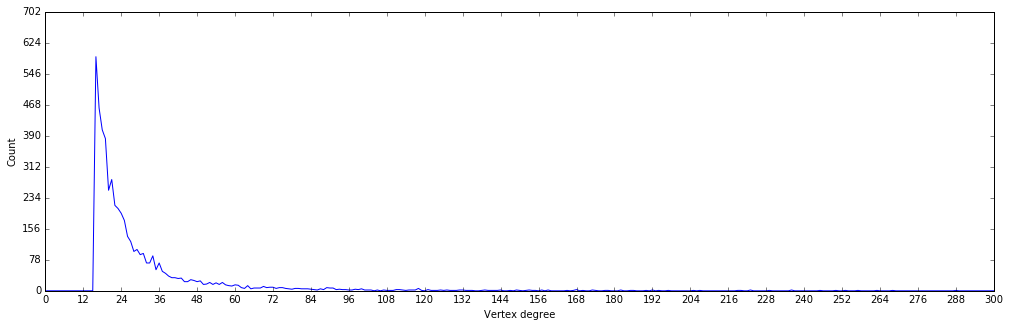

In [5]:
draw_distrib('bollobas-riordan-graph-distributions\output_5120_16.txt.distribution', 300, 700)